# Getting starting with eesampling library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the stratified sampling model, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. If you feel so inspired, make edits to the code in these cells and dig deeper.


    

# Background -- why this library

The `eesampling` library originated from a project lead by Recurve Analytics, Inc. and funded by the US Dept. of Energy designed to identify practical methods for analyzing energy efficiency which are robust to external shocks (e.g. COVID-19).  From June through September 2020, Recurve hosted a series of meetings with industry stakeholders to discuss methods for constructing comparison groups, with the goal of presenting a recommended standard method to the GRID working group, a subsidiary of the Linux Foundation for Energy.  During this time, Recurve developed Python software to implement stratified sampling and demonstrate its effectiveness in practice.  The `eesampling` library is the open-source Apache-licensed output of this process and is availabe to be used by anyone. 

There are four useful things you can do with this library:
- Generate synthetic data for testing and experimental purposes
- Construct a control group that is comparable to a treatment group, according to a specific stratification scheme
- Construct and view diagnostic plots to visualize the data and the stratification scheme
- Identify an optimal stratification scheme which minimizes error between treatment and control groups (coming soon)

This notebook will take you through each step in the process.


## Note on tutorial scope and related libraries

This tutorial assumes the reader has properly installed python and the eesampling package (pip install eesampling) and has a basic working knowledge of python syntax and usage. 

The `eesampling` library uses `pandas` data frames as its principle way of representing data, therefore all inputs and outputs are data frames; see [this tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) for information on how to use `pandas`.  The `plotnine` library is used to make visualizations which can be embedded in a Jupyter notebook or saved as .pngs; see [this website](https://plotnine.readthedocs.io/en/stable/) for information on `plotnine`.

If you need to install `eesampling` or `plotnine`, remove the `#` below and run the following cell to install the required libraries to use this notebook.

In [1]:
#!pip install eesampling pandas plotnine

## Viewing documentation

You can view code documentation by appending a question mark to a function and then executing that code, as in the following example:

In [2]:
import eesampling
eesampling.StratifiedSampling?

Init signature:
eesampling.StratifiedSampling(
    treatment_label='treatment',
    pool_label='pool',
    output_name='output',
)
Docstring:     
Perform stratified sampling on a treatment group and comparison pool.  

Input data must be provided in the form of two data frames, df_treatment and df_pool, 
which have identical columns.  These data frames should contain one row per meter, 
one ID column, and one or more numerical feature columns.  The comparison pool
will be stratified (i.e. binned) along one or more of these feature columns, and 
a comparison group will be selected such that the distribution of features in the 
comparison group is as close as possible to that of the treatment group.

Stratification columns must be configured as follows:

    m = StratifiedSampling()
    m.add_column('annual_usage', min_value=0, max_value=20000)
    m.add_column('summer_usage', min_value=0, max_value=1000)

In this case, `annual_usage` and `summer_usage` are feature columns that 
are pre

# Problem definition

Typcailly one begins with two populations of meters: a **treatment group**, and a **comparison pool**.  The treatment group consists of those meters for which savings needs to be tracked, e.g. if they represent customers participating in an energy efficiency program.  The comparison pool consists of all of the available meters that are not part of the treatment group.  The goal is to select a **comparison group** which is a subset of the comparison pool, such that the control group is **similar** to the treatment group.  The comparison group will then provide a realistic counterfactual compared to the treatment group and can be used to accurately estimate the impact of a program.

There are many ways to define similarity and many methods for constructing similar groups.  The stratified sampling approach was selected in particular because it offers a good balance in terms effectiveness, ease of implementation, and simplicity.  (Other methods e.g. site-based matching on Euclidean distance may eventually be added to this library; contributions welcome.)  We define stratified sampling as follows:

- Each meter is represented by a vector of numerical features, e.g. annual usage, summer peak usage, etc
- A small number of features, typically between 1 and 3 inclusive, are selected: this is the number of *dimensions*.
- The treatment group is divided up into a set of multidimensional bins according to a predefined binning configuration.
- The proportion of treatment meters present in each bin is computed.
- A set of meters is sampled from the comparison pool such that the sample is distributed amongst the bins in the same proportion as the treatment group.  The sample is called the comparison group.
- The treatment and comparison groups are compared using additional meter data, e.g. load shapes.
- (Optional) An optimal binning configuration is selected which minimizes error between treatment and control groups.


In order to use this library, it is therefore necessary to have the following data at hand:
- A data frame containing the treatment group, with one ID column, and a set of numerical feature columns, one row per meter;
- A data frame containing the comparison pool, in the same format;
- A data frame containing the treatment group data for equivalence, with one ID column, one feature name column, and one value column; e.g. for an annual monthly load shape, the feature name column might contain the month name, and there might be twelve rows per meter;
- A data frame containing the comparison pool data for equivalence, in the same format.

# Setting up input data

Ordinarily you would start with your own time-series meter data, but for our purposes we'll generate some very basic synthetic data.  `eesampling` provides some functions which generate populations of synthetic meters with randomly varying base and peak usage levels.  We'll use the following code to generate a population of 1000 treatment meters and 10000 comparison pool meters, and specify some consumption values for the treatment group that differ from the default, so that the groups are differently distributed.  The treatment group is specified by filtering the comparison pool along one of the available features (currently `winter_usage`, `summer_uage`, and `annual_usage`).  For this example, we'll assume our treatment group targets customers with usage above the 50th percentile in both summer and winter.

Once the population has been generated, we can create feature data and longitudinal data.  These functions take a few minutes to run upon first execution, but the results are cached to disk so subsequent runs will be fast.

In [3]:
from eesampling import SyntheticTreatmentPoolPopulation

In [4]:
filter = lambda df: df[(df.summer_usage > df.summer_usage.quantile(0.5)) & (df.winter_usage > df.winter_usage.quantile(0.5))]
population = SyntheticTreatmentPoolPopulation(n_treatment=1000, n_pool=10000, 
                                              treatment_filter_function=filter)

In [5]:
df_features= population.features()
df_pool = df_features[df_features['set']=='pool']
df_treatment = df_features[df_features['set']=='treatment']
df_equiv = population.features_monthly()

## Selecting features for stratification

Normally, you will compute a set of features from your time series meter traces, and then select a subset of those features to stratify on.  The feature computation step is up to you.  We recommend running the Caltrack model to derive heating and cooling coefficients and deriving features from these outputs.  Other techniques such as principle component analysis could be useful as well.  In general, aim for stratifying on between one and three features, and aim for orthoganal features if possible.  In the synthetic data, there are three features availalble: `summer_usage`, `winter_usage`, and `annual_usage` which are shown in the scatter plots below.  `annual_usage` is correlated with the other two, as you would expect, so we will stratify based on `summer_usage` and `winter_usage`.



In [6]:
import pandas as pd

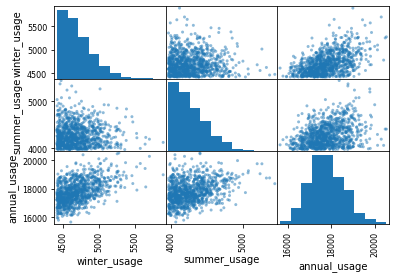

In [7]:
pd.plotting.scatter_matrix(df_treatment);

By plotting the two features below we can see that the treatment group and comparison pool are differently distributed, such that a random sample from the pool would not be a good counterfactual for the treatment group -- this is why we need stratified sampling.

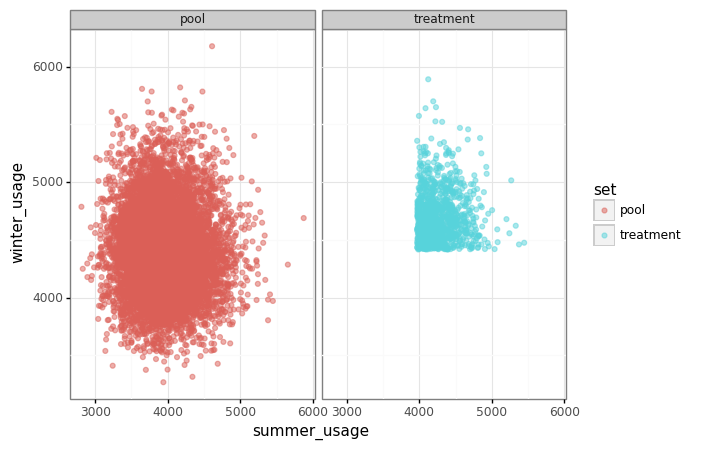

<ggplot: (8752042232525)>

In [8]:
import plotnine
from plotnine import *
ggplot(df_features, aes(x='summer_usage', y='winter_usage', color='set')) + geom_point(alpha=0.5) + facet_wrap("~set") + theme_bw()

# Stratified sampling usage overview 

To use stratified sampling, you must supply input data, a list of input columns to stratify on, and some configuration, according to the example below.   Additionally, you have the option of using the library to select an optimal configuration for you.  We'll first demonstrate the basic usage of the model, in which you supply all of the configuration information.

### Number of outputs 

The size of the comparison group is constrained by the size of the pool and by the degree to which the treatment group overlaps the pool in terms of the stratification columns.  For example, if the treatment group and pool are disjoint, no comparison group can be constructed; if only 5% of the pool overlaps the treatment group, then the effective available pool is constructed from that 5% of overlapping meters.  Generally, if you do not specify the output size, `eesampling` will construct the largest possible comparison group up to 5000 meters.   

In [9]:
from eesampling.model import StratifiedSampling

In [10]:
model = StratifiedSampling()
# specify number of bins, range cutoffs, whether to used equal-width or equal-proportion bins
model.add_column('summer_usage', n_bins=8, min_value_allowed=3000, max_value_allowed=6000, fixed_width=False)
model.add_column('winter_usage', n_bins=8, min_value_allowed=3000, max_value_allowed=6000, fixed_width=False)

In [11]:
model.fit_and_sample(df_treatment, df_pool)

In [12]:
# final comparison group
model.data_sample.df

,meter_id,winter_usage,summer_usage,annual_usage,set,_bin,_bin_label,_outlier_bin
8068,meter_8068,4621.469269,4242.192388,16952.583657,pool,MultBin: summer_usage_004__winter_usage_003,summer_usage_004__winter_usage_003,False
1091,meter_1091,4612.366101,4276.320347,17673.680056,pool,MultBin: summer_usage_004__winter_usage_003,summer_usage_004__winter_usage_003,False
5032,meter_5032,4646.420263,4311.541023,17809.435779,pool,MultBin: summer_usage_004__winter_usage_003,summer_usage_004__winter_usage_003,False
6909,meter_6909,4614.762788,4264.367677,18055.778708,pool,MultBin: summer_usage_004__winter_usage_003,summer_usage_004__winter_usage_003,False
6381,meter_6381,4600.201803,4266.026834,17971.531940,pool,MultBin: summer_usage_004__winter_usage_003,summer_usage_004__winter_usage_003,False
...,...,...,...,...,...,...,...,...
8256,meter_8256,4430.799800,4441.343419,16822.658392,pool,MultBin: summer_usage_006__winter_usage_000,summer_usage_006__winter_usage_000,False
9035,meter_9035,4420.032869,4443.452597,17516.070493,pool,MultBin: summer_usage_006__winter_usage_000,summer_usage_006__winter_usage_000,False
4861,meter_4861,4441.751077,4534.799685,17909.667055,pool,MultBin: summer_usage_006__winter_usage_000,summer_usage_006__winter_usage_000,False
2044,meter_2044,4446.730189,4488.984347,16572.626864,pool,MultBin: summer_usage_006__winter_usage_000,summer_usage_006__winter_usage_000,False


In [13]:
# bin count
model.diagnostics().count_bins()

,bin,n_treatment,n_pct_treatment,n_pool,n_pct_pool,n_sampled,n_pct_sampled
0,MultBin: summer_usage_004__winter_usage_003,24,0.024,31,0.017475,24,0.024
1,MultBin: summer_usage_001__winter_usage_001,22,0.022,22,0.012401,22,0.022
2,MultBin: summer_usage_002__winter_usage_005,21,0.021,31,0.017475,21,0.021
3,MultBin: summer_usage_002__winter_usage_001,21,0.021,38,0.021421,21,0.021
4,MultBin: summer_usage_000__winter_usage_005,21,0.021,24,0.013529,21,0.021
...,...,...,...,...,...,...,...
59,MultBin: summer_usage_004__winter_usage_006,10,0.010,32,0.018038,10,0.010
60,MultBin: summer_usage_001__winter_usage_005,10,0.010,30,0.016911,10,0.010
61,MultBin: summer_usage_004__winter_usage_004,10,0.010,25,0.014092,10,0.010
62,MultBin: summer_usage_002__winter_usage_002,10,0.010,37,0.020857,10,0.010


# Viewing diagnostic plots 

Once the model has been fit, you can view several plots which will show the treatment group, comparison pool, and the final sample (i.e. the comparison group).  If the model has worked correctly, then the sample should be distributed similarly to the treatment group.  There are three plots available:

1. Histograms, showing the distribution of each stratification parameter in one dimension;
2. Scatter plots, showing an XY-plot of data points for each pair of dimensions;
3. Quantile plots with equivalence, showing the quantile distribution of each dimension, along with t-test and ks-test p-values comparison the treatment and comparison groups.  

The t- and ks-tests can be used as a measure of equivalence, however we recommend using equivalence-based optimization discussed below for better results in practice.  

In [14]:
d = model.diagnostics()

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


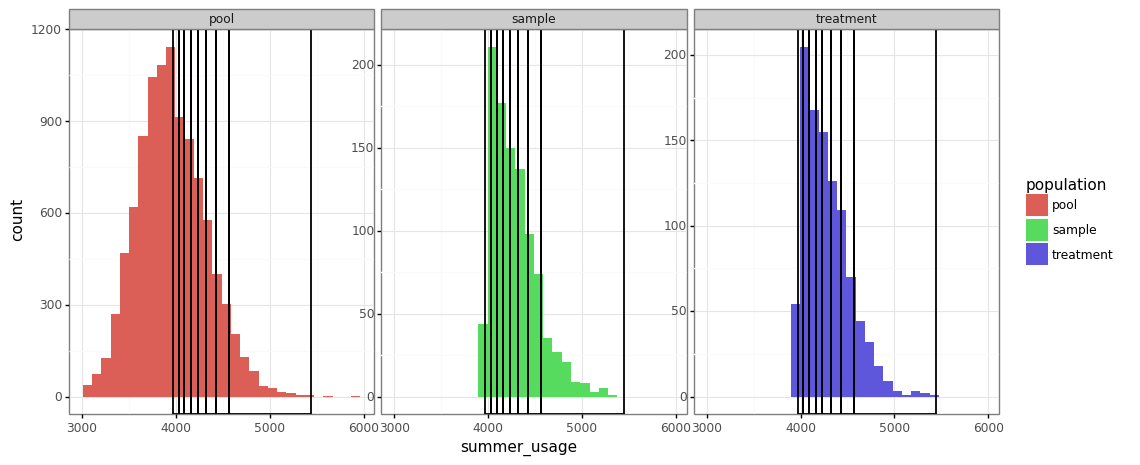

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


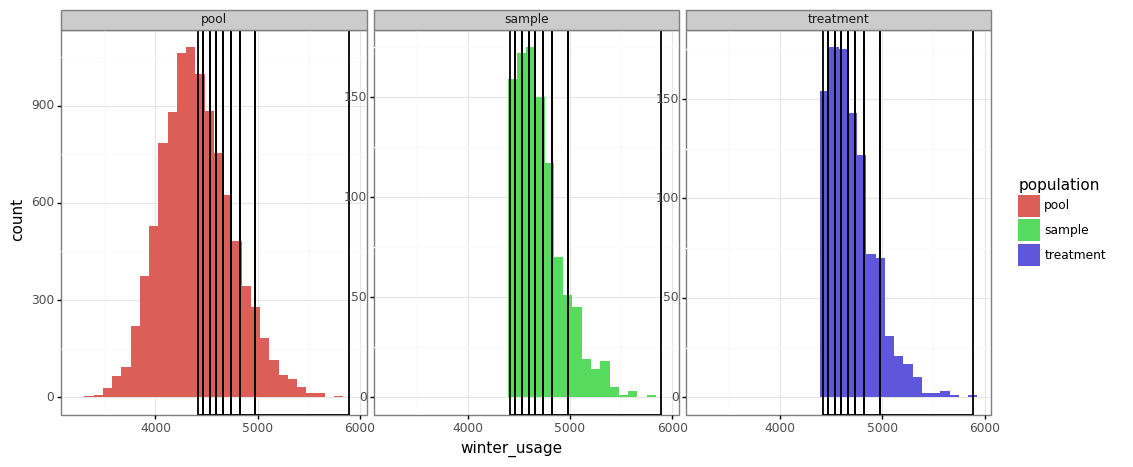

[<ggplot: (8752040544497)>, <ggplot: (8752137078245)>]

In [15]:
d.histogram()

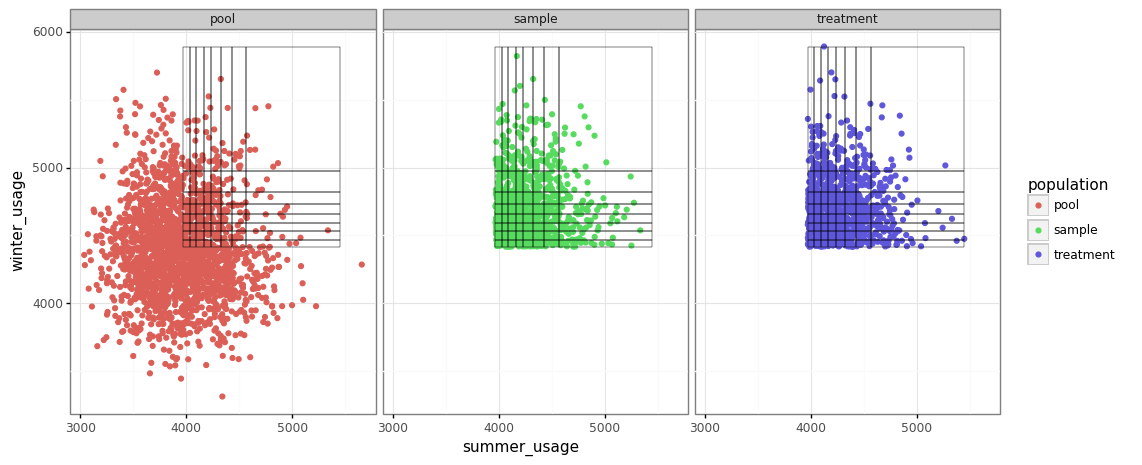

[<ggplot: (8752040395373)>]

In [16]:
d.scatter()

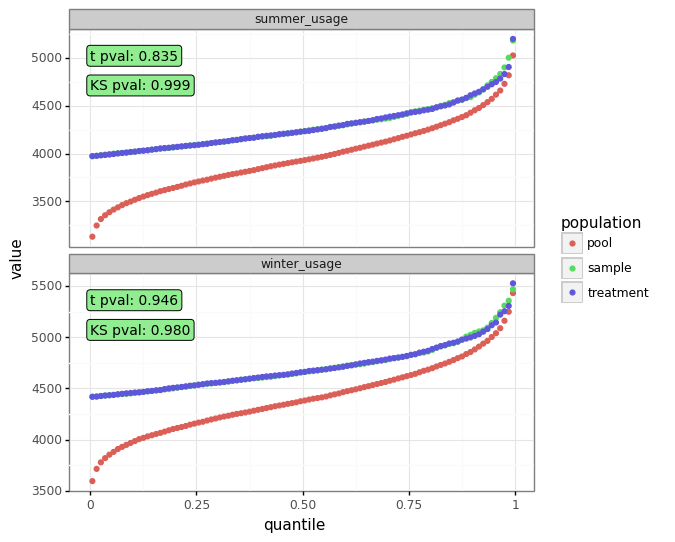

<ggplot: (8752035874957)>

In [17]:
d.quantile_equivalence()

# Equivalence-based optimization

The above method of stratified sampling is designed to match the distributions of one or more stratification parameters.  However, often in practice the desired outcome is to have a comparison group with similar usage patterns to a treatment group as measured through a load shape or similar set of time-series features.  To ensure that the load shapes are equivalent, you can use the `StratifiedSamplingBinSelector` which selects an optimal binning arrangement which minimizes load shape error between the treatment and comparison groups. 

In the following example, a bin selector is used to match on monthly load shapes.  

In [18]:
from eesampling.bin_selection import StratifiedSamplingBinSelector
from eesampling import StratifiedSampling
model2 = StratifiedSampling()
model2.add_column('summer_usage', min_value_allowed=2000, max_value_allowed=6000, fixed_width=False)
model2.add_column('winter_usage', min_value_allowed=3000, max_value_allowed=6000, fixed_width=False)

selector = StratifiedSamplingBinSelector(model2,
    df_treatment,
    df_pool,
    equivalence_feature_ids=df_equiv.index,
    equivalence_feature_matrix=df_equiv,
    equivalence_method="chisquare",
    df_id_col = "meter_id",
    min_n_bins=2,
    max_n_bins=8,
    random_seed=1,
)

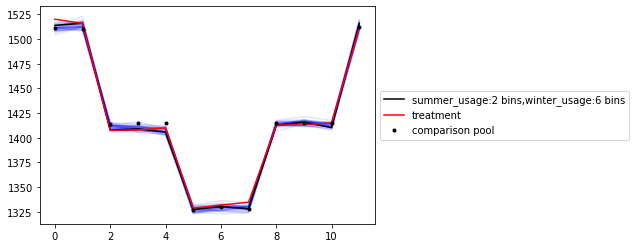

In [19]:
selector.plot_records_based_equiv_average()

The graph above shows the monthly load shape of the treatment group (red), the selected comparison group (black), other candidate comparison groups (blue), and the comparison pool (dots).  In this case, all of the candidates were a good match, so the selection process was probably unnecessary, however in more complex cases this method can be useful.  The final binning arrangement is available in the model object as follows:

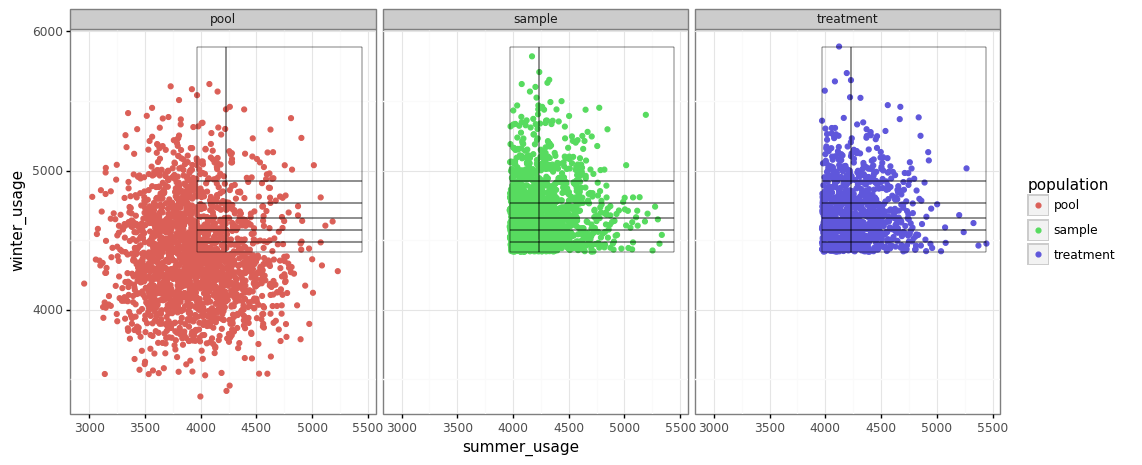

[<ggplot: (8752042356121)>]

In [20]:
model2.diagnostics().scatter()

In [21]:
model2.data_sample.df

,meter_id,winter_usage,summer_usage,annual_usage,set,_bin,_bin_label,_outlier_bin
4900,meter_4900,4629.253209,4668.427867,17491.078660,pool,MultBin: summer_usage_001__winter_usage_002,summer_usage_001__winter_usage_002,False
8551,meter_8551,4585.493980,4295.486574,16641.415346,pool,MultBin: summer_usage_001__winter_usage_002,summer_usage_001__winter_usage_002,False
2103,meter_2103,4633.964847,4282.279332,18154.154527,pool,MultBin: summer_usage_001__winter_usage_002,summer_usage_001__winter_usage_002,False
441,meter_441,4612.207104,4419.409473,18232.274971,pool,MultBin: summer_usage_001__winter_usage_002,summer_usage_001__winter_usage_002,False
9278,meter_9278,4596.383932,4319.119293,17859.547827,pool,MultBin: summer_usage_001__winter_usage_002,summer_usage_001__winter_usage_002,False
...,...,...,...,...,...,...,...,...
5133,meter_5133,4576.733511,4028.984294,17178.582839,pool,MultBin: summer_usage_000__winter_usage_002,summer_usage_000__winter_usage_002,False
247,meter_247,4591.742635,4012.285485,17595.100035,pool,MultBin: summer_usage_000__winter_usage_002,summer_usage_000__winter_usage_002,False
10508,meter_10508,4617.418499,4101.371562,17369.795131,pool,MultBin: summer_usage_000__winter_usage_002,summer_usage_000__winter_usage_002,False
2132,meter_2132,4644.115390,4098.598019,17389.838436,pool,MultBin: summer_usage_000__winter_usage_002,summer_usage_000__winter_usage_002,False


This concludes the tutorial.  For questions, comments, or issues, please raise a Github issue here:  
https://github.com/recurve-methods/comparison_groups/issues

We thank you for your interest and participation in this project and look forward to your feedback.